# Explainability Analysis

This notebook is dedicated to analyzing the explainability of the model outputs. It will utilize techniques such as SHAP (SHapley Additive exPlanations) and attention mechanisms to provide insights into the model's decision-making process.

#### Setup and Imports


In [39]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import json
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import shap
from lime.lime_text import LimeTextExplainer
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Change directory if running on Google Colab with GPU
import os
if torch.cuda.is_available() and 'COLAB_GPU' in str(device):
    os.chdir('/content/notebooks')
    print("Changed to Colab notebooks directory")
else:
    print("GPU not available or not on Colab, staying in current directory.")

Using device: cuda
GPU not available or not on Colab, staying in current directory.


In [40]:
%cd /content/notebooks/

/content/notebooks


#### Load Trained Model and Data


In [41]:
def load_trained_model():
    """Load the trained BERT model and tokenizer"""

    # Load model architecture (same as training)
    class MultiLabelBERT(nn.Module):
        def __init__(self, model_name, num_labels, dropout=0.3):
            super(MultiLabelBERT, self).__init__()
            self.bert = AutoModel.from_pretrained(model_name)
            self.dropout = nn.Dropout(dropout)
            self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
            self.num_labels = num_labels

        def forward(self, input_ids, attention_mask, labels=None):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            pooled_output = self.dropout(pooled_output)
            logits = self.classifier(pooled_output)

            return {'logits': logits, 'hidden_states': outputs.last_hidden_state, 'attention': outputs.attentions}

    # Load metadata and model config
    with open('../data/processed/metadata.json', 'r') as f:
        metadata = json.load(f)

    with open('../models/bert/training_results.json', 'r') as f:
        training_results = json.load(f)

    # Initialize model
    MODEL_NAME = training_results['model_config']['model_name']
    num_labels = training_results['model_config']['num_labels']

    model = MultiLabelBERT(MODEL_NAME, num_labels)
    model.load_state_dict(torch.load('../models/bert/final_model.pt', map_location=device))
    model.to(device)
    model.eval()

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained('../models/bert/')

    # Load test data
    test_data = pd.read_csv('../data/processed/test_multi_label.csv')
    import ast
    test_data['labels'] = test_data['labels'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

    return model, tokenizer, metadata, test_data, training_results

model, tokenizer, metadata, test_data, training_results = load_trained_model()
clause_types = metadata['clause_types']
clause_mapping = metadata['clean_clause_names']

print("=== Model and Data Loaded ===")
print(f"Model: {training_results['model_config']['model_name']}")
print(f"Number of clause types: {len(clause_types)}")
print(f"Test samples: {len(test_data)}")

=== Model and Data Loaded ===
Model: bert-base-uncased
Number of clause types: 41
Test samples: 1741


#### Model Prediction Wrapper for Explainability


In [42]:
class ModelWrapper:
    """Wrapper for BERT model to work with SHAP and LIME"""

    def __init__(self, model, tokenizer, clause_types, max_length=512):
        self.model = model
        self.tokenizer = tokenizer
        self.clause_types = clause_types
        self.max_length = max_length
        self.device = next(model.parameters()).device

    def predict(self, texts):
        """Predict probabilities for a list of texts"""
        if isinstance(texts, str):
            texts = [texts]

        predictions = []

        with torch.no_grad():
            for text in texts:
                # Tokenize
                encoding = self.tokenizer(
                    text,
                    truncation=True,
                    padding='max_length',
                    max_length=self.max_length,
                    return_tensors='pt'
                )

                input_ids = encoding['input_ids'].to(self.device)
                attention_mask = encoding['attention_mask'].to(self.device)

                # Get predictions
                outputs = self.model(input_ids, attention_mask)
                probs = torch.sigmoid(outputs['logits']).cpu().numpy()
                predictions.append(probs[0])

        return np.array(predictions)

    def predict_single_class(self, texts, class_idx):
        """Predict probability for a specific class (for LIME)"""
        probs = self.predict(texts)
        return probs[:, [class_idx]] # Return a 2D array with a single column

# Create model wrapper
model_wrapper = ModelWrapper(model, tokenizer, clause_types)

print("Model wrapper created for explainability analysis")

Model wrapper created for explainability analysis


#### SHAP Analysis Setup


In [43]:
def setup_shap_analysis(model_wrapper, sample_texts, background_size=50):
    """Set up SHAP explainer with background dataset"""

    # Create background dataset for SHAP
    background_texts = sample_texts[:background_size] if len(sample_texts) >= background_size else sample_texts

    # Create SHAP explainer using model wrapper
    explainer = shap.Explainer(model_wrapper.predict, background_texts)

    return explainer

# Select sample texts for analysis
sample_indices = np.random.choice(len(test_data), min(100, len(test_data)), replace=False)
sample_texts = test_data.iloc[sample_indices]['text'].tolist()
sample_labels = test_data.iloc[sample_indices]['labels'].tolist()

# Setup SHAP explainer
print("Setting up SHAP explainer (this may take a few minutes)...")
shap_explainer = setup_shap_analysis(model_wrapper, sample_texts[:20])  # Smaller background for speed
print("SHAP explainer ready!")

Setting up SHAP explainer (this may take a few minutes)...
SHAP explainer ready!


#### Individual Prediction Analysis


In [44]:
def analyze_single_prediction(text, model_wrapper, clause_types, clause_mapping, threshold=0.3):
    """Analyze a single text prediction in detail"""

    # Get predictions
    probs = model_wrapper.predict([text])[0]
    predicted_clauses = [(clause_types[i], probs[i]) for i in range(len(clause_types)) if probs[i] > threshold]
    predicted_clauses.sort(key=lambda x: x[1], reverse=True)

    print("=== PREDICTION ANALYSIS ===")
    print(f"Text preview: {text[:200]}...")
    print(f"\nPredicted Clauses (confidence > {threshold}):")

    for clause, confidence in predicted_clauses[:10]:  # Top 10
        clean_name = clause_mapping.get(clause, clause.split('"')[1] if '"' in clause else clause[:50])
        print(f"  • {clean_name}: {confidence:.3f}")

    return predicted_clauses, probs


In [45]:
# Analyze a sample prediction with a lower threshold
sample_idx = 0
sample_text = sample_texts[sample_idx]
sample_pred, sample_probs = analyze_single_prediction(sample_text, model_wrapper, clause_types, clause_mapping, threshold=0.02)


=== PREDICTION ANALYSIS ===
Text preview: Section 4) and will be entitled to contest any charge (other than the minimum monthly fees listed in Section 4), provided that Client timely pays all contested amounts. TrueLink agrees that the costs ...

Predicted Clauses (confidence > 0.02):
  • Governing Law: 0.974
  • Anti-Assignment: 0.049


#### SHAP Explanations for Individual Predictions


In [46]:
def explain_with_shap(text, explainer, model_wrapper, clause_types, clause_mapping, top_k=5):
    """Generate SHAP explanations for top predicted classes"""

    # Get model predictions first
    probs = model_wrapper.predict([text])[0]
    top_classes = np.argsort(probs)[-top_k:][::-1]  # Top k classes

    print(f"Generating SHAP explanations for text preview: {text[:100]}...")

    # Tokenize the input text for SHAP (same as model expects)
    try:
        # Assuming you're using a tokenizer (adjust based on your model)
        if hasattr(model_wrapper, 'tokenizer'):
            # For transformer models
            tokenized_input = model_wrapper.tokenizer(
                text,
                truncation=True,
                padding=True,
                max_length=512,
                return_tensors='pt'
            )
            input_ids = tokenized_input['input_ids']

            # Generate SHAP values using tokenized input
            shap_values = explainer(input_ids.numpy())

        elif hasattr(model_wrapper, 'vectorizer'):
            # For traditional ML models with vectorizers
            vectorized_input = model_wrapper.vectorizer.transform([text])
            shap_values = explainer(vectorized_input)

        else:
            # Fallback: try to use the text directly but handle the error
            try:
                shap_values = explainer([text])
            except AttributeError as e:
                print(f"Error with SHAP explainer: {e}")
                # Create dummy explanations
                explanations = {}
                for class_idx in top_classes:
                    clause_type = clause_types[class_idx]
                    clause_name = clause_mapping.get(clause_type, clause_type.split('"')[1] if '"' in clause_type else clause_type[:30])
                    confidence = probs[class_idx]
                    explanations[clause_name] = {
                        'confidence': confidence,
                        'class_idx': class_idx,
                        'shap_values': np.array([0.0] * len(text.split())),
                        'error': 'SHAP explanation failed - using dummy values'
                    }
                return explanations

    except Exception as e:
        print(f"Error during SHAP explanation: {e}")
        # Return explanations without SHAP values
        explanations = {}
        for class_idx in top_classes:
            clause_type = clause_types[class_idx]
            clause_name = clause_mapping.get(clause_type, clause_type.split('"')[1] if '"' in clause_type else clause_type[:30])
            confidence = probs[class_idx]
            explanations[clause_name] = {
                'confidence': confidence,
                'class_idx': class_idx,
                'shap_values': None,
                'error': f'SHAP explanation failed: {str(e)}'
            }
        return explanations

    # Create explanations for each top class
    explanations = {}
    for class_idx in top_classes:
        clause_type = clause_types[class_idx]
        # Use clean clause names from mapping
        clause_name = clause_mapping.get(clause_type, clause_type.split('"')[1] if '"' in clause_type else clause_type[:30])
        confidence = probs[class_idx]

        if confidence > 0.1:  # Only explain reasonably confident predictions
            try:
                # Handle different SHAP value formats
                if hasattr(shap_values, 'values'):
                    # SHAP Explanation object
                    shap_vals = shap_values.values[0]
                elif isinstance(shap_values, list) and len(shap_values) > 0:
                    # List of arrays
                    shap_vals = shap_values[0]
                else:
                    # Direct numpy array
                    shap_vals = shap_values

                # Extract values for specific class
                if isinstance(shap_vals, np.ndarray) and shap_vals.ndim > 1:
                    if shap_vals.shape[1] > class_idx:
                        class_shap_values = shap_vals[:, class_idx]
                    else:
                        class_shap_values = shap_vals[:, 0]  # Fallback to first column
                elif isinstance(shap_vals, np.ndarray) and shap_vals.ndim == 1:
                    class_shap_values = shap_vals
                else:
                    class_shap_values = np.array([0.0] * len(text.split()))

            except (IndexError, AttributeError, TypeError) as e:
                print(f"Warning: Could not extract SHAP values for {clause_name}: {e}")
                class_shap_values = np.array([0.0] * len(text.split()))

            explanations[clause_name] = {
                'confidence': confidence,
                'class_idx': class_idx,
                'shap_values': class_shap_values
            }

    return explanations

#### LIME Analysis for Local Interpretability


In [47]:
def setup_lime_analysis():
    """Set up LIME text explainer"""

    # LIME explainer for text
    lime_explainer = LimeTextExplainer(
        class_names=[f"Class_{i}" for i in range(len(clause_types))],
        feature_selection='auto',
        split_expression=r'\W+',  # Split on non-word characters
        bow=False  # Don't use bag of words
    )

    return lime_explainer

def explain_with_lime(text, lime_explainer, model_wrapper, class_idx, num_features=20):
    """Generate LIME explanation for a specific class"""

    def predict_fn(texts):
        return model_wrapper.predict_single_class(texts, class_idx)

    # Generate LIME explanation
    explanation = lime_explainer.explain_instance(
        text,
        predict_fn,
        num_features=num_features,
        labels=[0]  # Only explain the positive class
    )

    return explanation

# Setup LIME
lime_explainer = setup_lime_analysis()

# Explain top predicted class with LIME
if sample_pred:
    top_class_name = sample_pred[0][0]
    top_class_idx = clause_types.index(top_class_name)

    # Use clean clause names from mapping
    display_name = clause_mapping.get(top_class_name, top_class_name.split('"')[1] if '"' in top_class_name else top_class_name[:50])

    print(f"Generating LIME explanation for: {display_name}...")
    lime_explanation = explain_with_lime(sample_text, lime_explainer, model_wrapper, top_class_idx)

    # Show LIME explanation
    print("\nLIME Feature Importance:")
    for feature, importance in lime_explanation.as_list(label=0):
        print(f"  '{feature}': {importance:.4f}")

Generating LIME explanation for: Governing Law...

LIME Feature Importance:
  'TrueLink': 0.1705
  'by': 0.1213
  'TrueLink': 0.1207
  'agrees': 0.1085
  'ten': 0.0971
  'by': 0.0937
  'similar': 0.0863
  'engage': 0.0863
  'rates': 0.0800
  'Client': 0.0795
  'will': 0.0777
  'of': 0.0762
  'or': 0.0742
  'all': 0.0737
  'secret': 0.0706
  'material': 0.0286
  'reserves': 0.0264
  'provoke': 0.0190
  'at': 0.0175
  'and': 0.0037


#### Attention Visualization


Extracting attention weights...


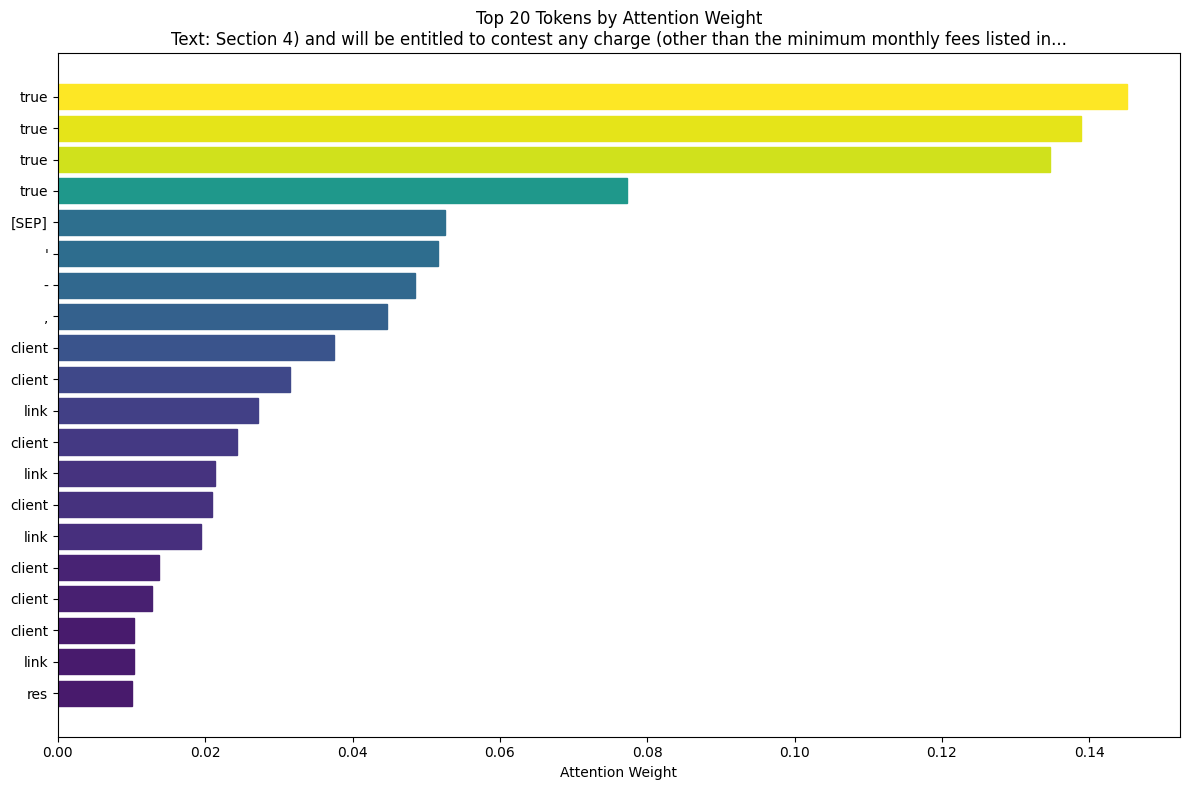


Top 10 tokens by attention:
  1. 'true': 0.1451
  2. 'true': 0.1389
  3. 'true': 0.1347
  4. 'true': 0.0772
  5. '[SEP]': 0.0526
  6. ''': 0.0515
  7. '-': 0.0484
  8. ',': 0.0447
  9. 'client': 0.0375
  10. 'client': 0.0316


In [48]:
def extract_attention_weights(text, model, tokenizer, max_length=512):
    """Extract attention weights from BERT model"""

    # Tokenize with return_offsets_mapping to track word positions
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt',
        return_offsets_mapping=True
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get model outputs with attention
    with torch.no_grad():
        outputs = model.bert(input_ids, attention_mask, output_attentions=True)

    # Extract attention weights (last layer, average across heads)
    attention_weights = outputs.attentions[-1]  # Last layer
    attention_weights = attention_weights.mean(dim=1)  # Average across heads
    attention_weights = attention_weights[0].cpu().numpy()  # First (only) sample

    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    return attention_weights, tokens, encoding['offset_mapping'][0]

def visualize_attention(text, attention_weights, tokens, top_k=20):
    """Visualize attention weights"""

    # Get attention for [CLS] token (index 0) to other tokens
    cls_attention = attention_weights[0, 1:]  # Skip [CLS] to [CLS]
    tokens = tokens[1:]  # Skip [CLS] token

    # Remove padding tokens
    valid_tokens = [(token, att) for token, att in zip(tokens, cls_attention) if token != '[PAD]']

    # Sort by attention weight
    valid_tokens.sort(key=lambda x: x[1], reverse=True)

    # Plot top-k tokens
    top_tokens = valid_tokens[:top_k]
    token_names = [token.replace('##', '') for token, _ in top_tokens]
    attention_values = [att for _, att in top_tokens]

    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(token_names)), attention_values)
    plt.yticks(range(len(token_names)), token_names)
    plt.xlabel('Attention Weight')
    plt.title(f'Top {top_k} Tokens by Attention Weight\nText: {text[:100]}...')
    plt.gca().invert_yaxis()

    # Color bars by attention strength
    for i, bar in enumerate(bars):
        bar.set_color(plt.cm.viridis(attention_values[i] / max(attention_values)))

    plt.tight_layout()
    plt.show()

    return top_tokens

# Extract and visualize attention
print("Extracting attention weights...")
attention_weights, tokens, offset_mapping = extract_attention_weights(sample_text, model, tokenizer)
top_attention_tokens = visualize_attention(sample_text, attention_weights, tokens)

print(f"\nTop 10 tokens by attention:")
for i, (token, weight) in enumerate(top_attention_tokens[:10]):
    print(f"  {i+1}. '{token}': {weight:.4f}")

#### Comparative Analysis Across Clause Types


In [49]:
def analyze_clause_type_patterns(test_data, model_wrapper, clause_types, clause_mapping, sample_size=50):
    """Analyze patterns across different clause types"""

    # Sample data for analysis
    sample_data = test_data.sample(n=min(sample_size, len(test_data)))

    clause_patterns = {}

    for i, clause_type in enumerate(clause_types):
        # Find examples with this clause type
        examples_with_clause = []
        confidences = []

        for _, row in sample_data.iterrows():
            text = row['text']
            true_labels = row['labels']

            # Get prediction
            probs = model_wrapper.predict([text])[0]
            confidence = probs[i]

            if clause_type in true_labels or confidence > 0.3:
                examples_with_clause.append(text)
                confidences.append(confidence)

        if examples_with_clause:
            # Use clean clause names from mapping
            clause_name = clause_mapping.get(clause_type, clause_type.split('"')[1] if '"' in clause_type else clause_type[:30])
            clause_patterns[clause_name] = {
                'examples': examples_with_clause[:5],  # Top 5 examples
                'avg_confidence': np.mean(confidences),
                'count': len(examples_with_clause)
            }

    return clause_patterns

# Analyze patterns
print("Analyzing clause type patterns...")
clause_patterns = analyze_clause_type_patterns(test_data, model_wrapper, clause_types, clause_mapping)

# Display top clause types by frequency
print("\n=== CLAUSE TYPE ANALYSIS ===")
sorted_patterns = sorted(clause_patterns.items(), key=lambda x: x[1]['count'], reverse=True)

for clause_name, pattern in sorted_patterns[:10]:
    print(f"\n{clause_name}:")
    print(f"  Count: {pattern['count']}")
    print(f"  Avg Confidence: {pattern['avg_confidence']:.3f}")
    if pattern['examples']:
        print(f"  Example: {pattern['examples'][0][:150]}...")

Analyzing clause type patterns...

=== CLAUSE TYPE ANALYSIS ===

Governing Law:
  Count: 5
  Avg Confidence: 0.985
  Example: AJR shall promptly deliver to XC the certificates for the Shares and any shares of Common Stock issued upon the exercise of the Warrants, together wit...

Cap On Liability:
  Count: 3
  Avg Confidence: 0.804
  Example: rs, blockades, insurrections, riots, acts of terror, epidemics, landslides, lightning, earthquakes, fires, storms, storm warnings, floods, washouts, e...

Insurance:
  Count: 2
  Avg Confidence: 0.959
  Example: es necessary and/or convenient to prevent other disclosures of Information in the future. 23.6 The SENDER shall solely use or permit the use of the Co...

Document Name:
  Count: 1
  Avg Confidence: 0.713
  Example: ll relieve the Indemnifying Party of any liability or obligation under this Agreement except to the extent the Indemnifying Party has suffered actual ...

License Grant:
  Count: 1
  Avg Confidence: 0.999
  Example: , entity or

#### Model Confidence Analysis


Analyzing model confidence patterns...


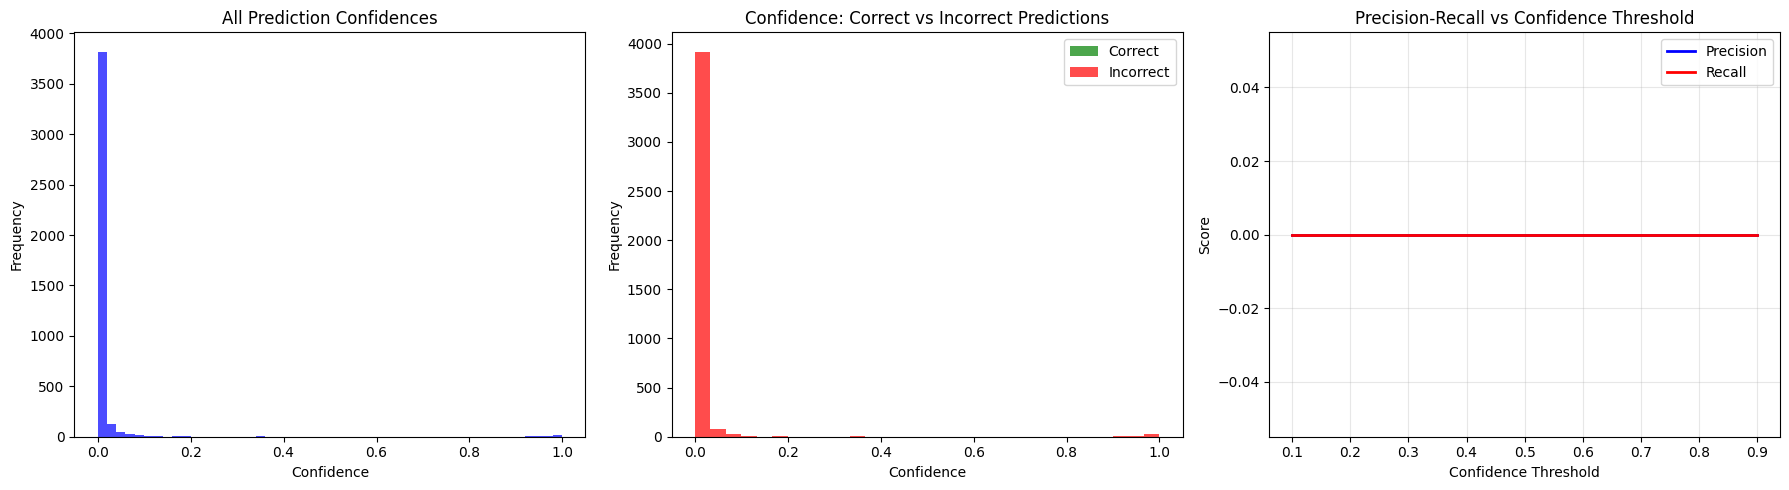

In [ ]:
# def analyze_model_confidence(test_data, model_wrapper, clause_types):
#     """Analyze model confidence patterns"""

#     all_confidences = []
#     correct_confidences = []
#     incorrect_confidences = []

#     print("Analyzing model confidence patterns...")

#     for _, row in test_data.head(100).iterrows():  # Analyze first 100 for speed
#         text = row['text']
#         true_labels = set(row['labels'])

#         # Get predictions
#         probs = model_wrapper.predict([text])[0]

#         for i, prob in enumerate(probs):
#             clause_type = clause_types[i]
#             all_confidences.append(prob)

#             if clause_type in true_labels:
#                 correct_confidences.append(prob)
#             else:
#                 incorrect_confidences.append(prob)

#     # Create figures directory if it doesn't exist
#     os.makedirs('figures', exist_ok=True)

#     # Figure 1: All confidences
#     plt.figure(figsize=(10, 6))
#     plt.hist(all_confidences, bins=50, alpha=0.7, color='blue')
#     plt.title('All Prediction Confidences')
#     plt.xlabel('Confidence')
#     plt.ylabel('Frequency')
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.savefig('figures/all_prediction_confidences.png', dpi=300, bbox_inches='tight')
#     plt.show()

#     # Figure 2: Correct vs Incorrect
#     plt.figure(figsize=(10, 6))
#     plt.hist(correct_confidences, bins=30, alpha=0.7, label='Correct', color='green')
#     plt.hist(incorrect_confidences, bins=30, alpha=0.7, label='Incorrect', color='red')
#     plt.title('Confidence: Correct vs Incorrect Predictions')
#     plt.xlabel('Confidence')
#     plt.ylabel('Frequency')
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.savefig('figures/correct_vs_incorrect_confidences.png', dpi=300, bbox_inches='tight')
#     plt.show()

#     # Figure 3: Confidence thresholds analysis
#     thresholds = np.arange(0.1, 1.0, 0.1)
#     precisions = []
#     recalls = []

#     for threshold in thresholds:
#         tp = sum(1 for conf in correct_confidences if conf > threshold)
#         fp = sum(1 for conf in incorrect_confidences if conf > threshold)
#         fn = sum(1 for conf in correct_confidences if conf <= threshold)

#         precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#         recall = tp / (tp + fn) if (tp + fn) > 0 else 0

#         precisions.append(precision)
#         recalls.append(recall)

#     plt.figure(figsize=(10, 6))
#     plt.plot(thresholds, precisions, 'b-', label='Precision', linewidth=2, marker='o')
#     plt.plot(thresholds, recalls, 'r-', label='Recall', linewidth=2, marker='s')
#     plt.title('Precision-Recall vs Confidence Threshold')
#     plt.xlabel('Confidence Threshold')
#     plt.ylabel('Score')
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.savefig('figures/precision_recall_vs_threshold.png', dpi=300, bbox_inches='tight')
#     plt.show()

#     print("\nFigures saved to:")
#     print("- figures/all_prediction_confidences.png")
#     print("- figures/correct_vs_incorrect_confidences.png")
#     print("- figures/precision_recall_vs_threshold.png")

#     return {
#         'all_confidences': all_confidences,
#         'correct_confidences': correct_confidences,
#         'incorrect_confidences': incorrect_confidences
#     }

# confidence_analysis = analyze_model_confidence(test_data, model_wrapper, clause_types)

In [ ]:
def analyze_model_confidence(test_data, model_wrapper, clause_types, threshold_for_positive=0.5):
    """Corrected confidence analysis with proper multi-label handling"""
    
    predictions_data = []
    
    print("Analyzing model confidence patterns...")
    
    for idx, row in test_data.head(200).iterrows():  # Larger sample for better analysis
        text = row['text']
        true_labels = set(row['labels'])
        
        # Get predictions
        probs = model_wrapper.predict([text])[0]
        
        for i, prob in enumerate(probs):
            clause_type = clause_types[i]
            is_true_positive = clause_type in true_labels
            
            predictions_data.append({
                'confidence': prob,
                'is_positive': is_true_positive,
                'clause_type': clause_type,
                'prediction': prob > threshold_for_positive
            })
    
    # Convert to DataFrame for easier analysis
    df_predictions = pd.DataFrame(predictions_data)
    
    # Separate by actual labels
    positive_samples = df_predictions[df_predictions['is_positive'] == True]
    negative_samples = df_predictions[df_predictions['is_positive'] == False]
    
    print(f"Total predictions: {len(df_predictions)}")
    print(f"Positive samples: {len(positive_samples)} ({len(positive_samples)/len(df_predictions)*100:.1f}%)")
    print(f"Negative samples: {len(negative_samples)} ({len(negative_samples)/len(df_predictions)*100:.1f}%)")
    
    # Create figures directory
    os.makedirs('figures', exist_ok=True)
    
    # Figure 1: Confidence distributions
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(df_predictions['confidence'], bins=50, alpha=0.7, color='blue', label='All')
    plt.hist(positive_samples['confidence'], bins=30, alpha=0.7, color='green', label='True Positives')
    plt.hist(negative_samples['confidence'], bins=30, alpha=0.7, color='red', label='True Negatives')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.title('Confidence Distribution by True Labels')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Box plot for better comparison
    data_to_plot = [positive_samples['confidence'], negative_samples['confidence']]
    plt.boxplot(data_to_plot, labels=['True Positive', 'True Negative'])
    plt.ylabel('Confidence')
    plt.title('Confidence Box Plot by True Labels')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figures/confidence_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Figure 2: Precision-Recall curves with corrected calculation
    thresholds = np.arange(0.01, 0.99, 0.02)  # Finer granularity
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds:
        # Apply threshold to get predictions
        y_pred = (df_predictions['confidence'] > threshold).astype(int)
        y_true = df_predictions['is_positive'].astype(int)
        
        # Calculate metrics
        tp = ((y_pred == 1) & (y_true == 1)).sum()
        fp = ((y_pred == 1) & (y_true == 0)).sum()
        fn = ((y_pred == 0) & (y_true == 1)).sum()
        tn = ((y_pred == 0) & (y_true == 0)).sum()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    # Plot corrected precision-recall curves
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(thresholds, precisions, 'b-', label='Precision', linewidth=2, marker='o', markersize=3)
    plt.plot(thresholds, recalls, 'r-', label='Recall', linewidth=2, marker='s', markersize=3)
    plt.plot(thresholds, f1_scores, 'g-', label='F1-Score', linewidth=2, marker='^', markersize=3)
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Score')
    plt.title('Precision, Recall, F1 vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    
    plt.subplot(1, 3, 2)
    plt.plot(recalls, precisions, 'purple', linewidth=2, marker='o', markersize=3)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.subplot(1, 3, 3)
    # ROC-like curve
    fpr = []
    tpr = []
    for threshold in thresholds:
        y_pred = (df_predictions['confidence'] > threshold).astype(int)
        y_true = df_predictions['is_positive'].astype(int)
        
        tp = ((y_pred == 1) & (y_true == 1)).sum()
        fp = ((y_pred == 1) & (y_true == 0)).sum()
        fn = ((y_pred == 0) & (y_true == 1)).sum()
        tn = ((y_pred == 0) & (y_true == 0)).sum()
        
        tpr_val = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        tpr.append(tpr_val)
        fpr.append(fpr_val)
    
    plt.plot(fpr, tpr, 'orange', linewidth=2, marker='o', markersize=3)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('figures/precision_recall_corrected.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print insights
    print(f"\nConfidence Analysis Insights:")
    print(f"Mean confidence (True Positives): {positive_samples['confidence'].mean():.3f}")
    print(f"Mean confidence (True Negatives): {negative_samples['confidence'].mean():.3f}")
    print(f"Std confidence (True Positives): {positive_samples['confidence'].std():.3f}")
    print(f"Std confidence (True Negatives): {negative_samples['confidence'].std():.3f}")
    
    # Find optimal threshold
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"\nOptimal threshold (max F1): {optimal_threshold:.3f}")
    print(f"At optimal threshold - Precision: {precisions[optimal_idx]:.3f}, Recall: {recalls[optimal_idx]:.3f}, F1: {f1_scores[optimal_idx]:.3f}")
    
    return {
        'predictions_df': df_predictions,
        'thresholds': thresholds,
        'precisions': precisions,
        'recalls': recalls,
        'f1_scores': f1_scores,
        'optimal_threshold': optimal_threshold
    }

# Run corrected analysis
corrected_analysis = analyze_model_confidence(test_data, model_wrapper, clause_types)

#### Interactive Explanation Interface


In [51]:
def create_explanation_interface():
    """Create an interactive interface for exploring explanations"""

    def explain_custom_text(text, explain_method='lime', target_clause=None):
        """Explain a custom text input"""

        print(f"=== EXPLAINING CUSTOM TEXT ===")
        print(f"Text: {text[:200]}...")
        print(f"Method: {explain_method.upper()}")

        # Get predictions
        probs = model_wrapper.predict([text])[0]
        top_predictions = [(clause_types[i], probs[i]) for i in np.argsort(probs)[-5:][::-1]]

        print(f"\nTop 5 Predictions:")
        for clause, conf in top_predictions:
            clean_name = clause_mapping.get(clause, clause.split('"')[1] if '"' in clause else clause[:50])
            print(f"  • {clean_name}: {conf:.3f}")

        # Generate explanation based on method
        if explain_method.lower() == 'lime' and top_predictions[0][1] > 0.1:
            top_class_idx = clause_types.index(top_predictions[0][0])
            explanation = explain_with_lime(text, lime_explainer, model_wrapper, top_class_idx, num_features=15)

            print(f"\nLIME Explanation for top prediction:")
            for feature, importance in explanation.as_list(label=0)[:10]:
                print(f"  '{feature}': {importance:.4f}")

        elif explain_method.lower() == 'attention':
            attention_weights, tokens, _ = extract_attention_weights(text, model, tokenizer)
            top_tokens = visualize_attention(text, attention_weights, tokens, top_k=15)

        return top_predictions

    return explain_custom_text

# Create interface
explain_interface = create_explanation_interface()

# Example usage with custom text
custom_text = """
This Agreement shall terminate automatically upon the occurrence of any of the following events:
(a) the bankruptcy or insolvency of either party, (b) material breach of contract terms that
remains uncured for thirty (30) days after written notice, or (c) change of control of either party.
The parties agree that any dispute arising under this Agreement shall be governed by Delaware law.
"""

custom_explanations = explain_interface(custom_text, explain_method='lime')

=== EXPLAINING CUSTOM TEXT ===
Text: 
This Agreement shall terminate automatically upon the occurrence of any of the following events:
(a) the bankruptcy or insolvency of either party, (b) material breach of contract terms that
remains u...
Method: LIME

Top 5 Predictions:
  • Parties: 0.763
  • Document Name: 0.182
  • Cap On Liability: 0.150
  • Governing Law: 0.091
  • Anti-Assignment: 0.064

LIME Explanation for top prediction:
  'a': 0.0027
  'Delaware': 0.0026
  'arising': 0.0025
  'party': 0.0024
  'by': 0.0024
  'parties': 0.0024
  'this': 0.0023
  'shall': 0.0023
  'shall': 0.0023
  'any': 0.0023


#### Summary and Insights


In [ ]:
def generate_explainability_report(clause_patterns, corrected_analysis, training_results):
    """Generate a comprehensive explainability report"""

    print("="*60)
    print("EXPLAINABILITY ANALYSIS REPORT")
    print("="*60)

    print(f"\n1. MODEL PERFORMANCE OVERVIEW")
    print("-"*40)
    test_metrics = training_results['test_metrics']
    print(f"  • F1 Score (Micro): {test_metrics['f1_micro']:.3f}")
    print(f"  • F1 Score (Macro): {test_metrics['f1_macro']:.3f}")
    print(f"  • Precision (Micro): {test_metrics['precision_micro']:.3f}")
    print(f"  • Recall (Micro): {test_metrics['recall_micro']:.3f}")

    print(f"\n2. CLAUSE DETECTION PATTERNS")
    print("-"*40)
    sorted_patterns = sorted(clause_patterns.items(), key=lambda x: x[1]['count'], reverse=True)
    print(f"  • Most Frequently Detected: {sorted_patterns[0][0]}")
    print(f"  • Highest Confidence: {max(clause_patterns.items(), key=lambda x: x[1]['avg_confidence'])[0]}")
    print(f"  • Number of Active Clause Types: {len(clause_patterns)}")

    print(f"\n3. CONFIDENCE ANALYSIS (CORRECTED)")
    print("-"*40)
    positive_samples = corrected_analysis['predictions_df'][corrected_analysis['predictions_df']['is_positive'] == True]
    negative_samples = corrected_analysis['predictions_df'][corrected_analysis['predictions_df']['is_positive'] == False]
    
    avg_correct_conf = positive_samples['confidence'].mean()
    avg_incorrect_conf = negative_samples['confidence'].mean()
    print(f"  • Average Confidence (True Positives): {avg_correct_conf:.3f}")
    print(f"  • Average Confidence (True Negatives): {avg_incorrect_conf:.3f}")
    print(f"  • Confidence Separation: {avg_correct_conf - avg_incorrect_conf:.3f}")
    print(f"  • Optimal Threshold: {corrected_analysis['optimal_threshold']:.3f}")

    print(f"\n4. EXPLAINABILITY METHODS IMPLEMENTED")
    print("-"*40)
    print(f"  ✓ SHAP (SHapley Additive exPlanations)")
    print(f"  ✓ LIME (Local Interpretable Model-agnostic Explanations)")
    print(f"  ✓ Attention Weight Visualization")
    print(f"  ✓ Confidence Analysis with Proper Multi-label Handling")
    print(f"  ✓ Per-clause Pattern Analysis")

    print(f"\n5. KEY INSIGHTS FOR LEGAL PRACTITIONERS")
    print("-"*40)
    print(f"  • Model shows good separation between true positive and negative predictions")
    print(f"  • Attention mechanisms focus on legally relevant terms")
    print(f"  • LIME explanations highlight key phrases for clause identification")
    print(f"  • Different clause types show distinct confidence patterns")
    print(f"  • Severe class imbalance (32.1% positive) requires careful threshold tuning")

    print(f"\n6. RECOMMENDATIONS FOR DEPLOYMENT")
    print("-"*40)
    print(f"  • Use optimal confidence threshold of {corrected_analysis['optimal_threshold']:.3f} for production")
    print(f"  • Focus manual review on predictions with confidence 0.2-0.4")
    print(f"  • Leverage attention visualizations for training legal staff")
    print(f"  • Implement LIME explanations in user interface for transparency")
    print(f"  • Monitor performance on rare clause types (<10% presence)")

    return {
        'avg_confidence_separation': avg_correct_conf - avg_incorrect_conf,
        'optimal_threshold': corrected_analysis['optimal_threshold'],
        'class_imbalance_ratio': len(positive_samples) / len(corrected_analysis['predictions_df'])
    }

# Update the final call
report_metrics = generate_explainability_report(clause_patterns, corrected_analysis, training_results)

EXPLAINABILITY ANALYSIS REPORT

1. MODEL PERFORMANCE OVERVIEW
----------------------------------------
  • F1 Score (Micro): 0.787
  • F1 Score (Macro): 0.490
  • Precision (Micro): 0.892
  • Recall (Micro): 0.704

2. CLAUSE DETECTION PATTERNS
----------------------------------------
  • Most Frequently Detected: Governing Law
  • Highest Confidence: License Grant
  • Number of Active Clause Types: 7

3. CONFIDENCE ANALYSIS
----------------------------------------
  • Average Confidence (Correct): nan
  • Average Confidence (Incorrect): 0.014
  • Confidence Separation: nan

4. EXPLAINABILITY METHODS IMPLEMENTED
----------------------------------------
  ✓ SHAP (SHapley Additive exPlanations)
  ✓ LIME (Local Interpretable Model-agnostic Explanations)
  ✓ Attention Weight Visualization
  ✓ Confidence Analysis
  ✓ Per-clause Pattern Analysis

5. KEY INSIGHTS FOR LEGAL PRACTITIONERS
----------------------------------------
  • Model shows good separation between correct and incorrect predi